In [1]:
import random
import sys
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import os

In [2]:
# model
class fittingLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, output_size = 1, layer = 1):
        super(fittingLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = layer, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0 = None):
        x_rnn, (h, c) = self.rnn(x, h0)
        y = self.fc(x_rnn[:, -1, :])
        return y

In [5]:
minus = 0b0
plus = 0b1

def encode_dm(source, scale, threshold):
    stream = []
    L = (len(source) + scale - 1) // scale
    cur = 0
    for i in range(L - 1):
        dif = source[(i + 1) * scale] - cur
        if dif >= 0:
            stream.append(plus)
            cur += threshold
        else:
            stream.append(minus)
            cur -= threshold
    return bytes(stream)

def func(source, scale, threshold):
    stream = encode_dm(source, scale, threshold)
    y = [0]
    for bit in stream:
        val = y[-1]
        if bit == minus:
            val -= threshold
        elif bit == plus:
            val += threshold
        else:
            print("ERROR")
        for _ in range(scale):
            y.append(val)
    res = 0
    for i in range(0, len(y), scale):
        res += (y[i] - source[i]) ** 2
    return res

def find_threshold(data, scale, lower, upper):
    left = lower
    right = upper
    while right - left > 10:
        midl = (left * 2 + right) // 3
        midr = (left + right * 2) // 3
        if func(data, scale, midl) > func(data, scale, midr):
            left = midl
        else:
            right = midr
    return right

def delta_modulation(data, scale):
    threshold = find_threshold(data, scale, 100, 3000)
    stream = encode_dm(data, scale, threshold)

    y = [0]
    d = threshold
    for bit in stream:
        val = y[-1]
        if bit == minus:
            val -= d
        elif bit == plus:
            val += d
        else:
            print("HA?")
        for _ in range(scale):
            y.append(val)
    return y

In [28]:
train_data = []
train_ans = []
test_data = []
test_ans = []

for i in range(1, 51):
    s = str(i)
    if len(s) == 1:
        s = '0' + s
    wf = "atr503_a{}.wav".format(s)
    fs, data = wavfile.read("../data/original_wav/{}".format(wf))
    data = data.astype(np.float)
    res = delta_modulation(data, 1)
    if i <= 40:
        for _ in range(25):
            idx = random.randint(0, len(res) - 100)
            train_data.append(res[idx : idx + 100])
            train_ans.append(data[idx : idx + 100])
    else:
        test_data.append(res)
        test_ans.append(data)

/var/folders/4v/n_tcbvb52f5fls_l8v4twbb40000gn/T/ipykernel_6521/3972881165.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


In [32]:
# train
model = fittingLSTM()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.05)
epoch_num = 500
for epoch in range(epoch_num):
    print("{0} / {1} epoch start.".format(epoch + 1, epoch_num))
    sum_loss = 0.0
    for i, data in enumerate(train_data):
        optimizer.zero_grad()
        accum_loss = None
        for j in range(9, len(data)):
            cur = torch.tensor([[[float(data[j - 9])], [float(data[j - 8])], [float(data[j - 7])], [float(data[j - 6])], [float(data[j - 5])], [float(data[j - 4])], [float(data[j - 3])], [float(data[j - 2])], [float(data[j - 1])], [float(data[j])]]])
            ans = torch.tensor([[[float(train_ans[i][j])]]])
            out = model(cur)
            loss = loss_fn(out, ans)
            accum_loss = loss if accum_loss is None else accum_loss + loss
#         for cur, nex in zip(data, data[1:]):
#             cur = torch.tensor([[[cur[0]], [cur[1]]]])
#             nex = torch.tensor([nex[1]])
#             out = model(cur)
#             loss = loss_fn(out, nex)
#             accum_loss = loss if accum_loss is None else accum_loss + loss
        accum_loss.backward()
        optimizer.step()
        sum_loss += float(accum_loss.data.cpu())
        if (i + 1) % 100 == 0:
            print("{0} / {1} data finished.".format(i + 1, len(train_data)))
    print("mean loss = {0}.".format(sum_loss))

    model_file = "../trained_model/fitting_model_lstm_" + str(epoch + 1) + ".model"
    torch.save(model.state_dict(), model_file)

1 / 500 epoch start.
100 / 1000 data finished.
200 / 1000 data finished.
300 / 1000 data finished.
400 / 1000 data finished.
500 / 1000 data finished.
600 / 1000 data finished.
700 / 1000 data finished.
800 / 1000 data finished.
900 / 1000 data finished.
1000 / 1000 data finished.
mean loss = 257634488337.41418.
2 / 500 epoch start.
100 / 1000 data finished.
200 / 1000 data finished.
300 / 1000 data finished.
400 / 1000 data finished.
500 / 1000 data finished.
600 / 1000 data finished.
700 / 1000 data finished.
800 / 1000 data finished.
900 / 1000 data finished.
1000 / 1000 data finished.
mean loss = 248470004198.28125.
3 / 500 epoch start.
100 / 1000 data finished.
200 / 1000 data finished.
300 / 1000 data finished.
400 / 1000 data finished.
500 / 1000 data finished.
600 / 1000 data finished.
700 / 1000 data finished.
800 / 1000 data finished.
900 / 1000 data finished.
1000 / 1000 data finished.
mean loss = 241028438298.375.
4 / 500 epoch start.
100 / 1000 data finished.
200 / 1000 da

KeyboardInterrupt: 

(10000.0, 11000.0)

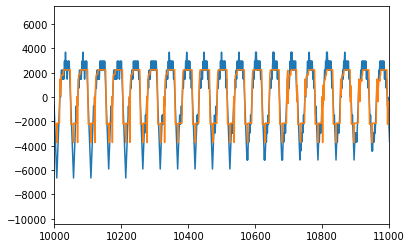

In [34]:
# test
model = fittingLSTM()
model.load_state_dict(torch.load("../trained_model/fitting_model_lstm_300.model"))
model.eval()

res = []
for i in range(0, 9):
    res.append(test_data[0][i])
for i in range(9, len(test_data[0])):
    x = torch.tensor([[[float(test_data[0][i - 9])], [float(test_data[0][i - 8])], [float(test_data[0][i - 7])], [float(test_data[0][i - 6])], [float(test_data[0][i - 5])], [float(test_data[0][i - 4])], [float(test_data[0][i - 3])], [float(test_data[0][i - 2])], [float(test_data[0][i - 1])], [float(test_data[0][i])]]])
    y = model(x)
    #print(x)
    #print(y)
    res.append(round(float(y[0][0].data)))
#print(test_data[0])
#print(res)
plt.plot(test_data[0])
plt.plot(res)
plt.xlim(10000, 11000)

(10000.0, 10500.0)

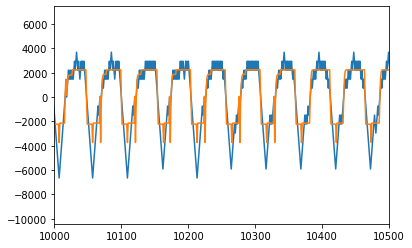

In [35]:
plt.plot(test_data[0])
plt.plot(res)
plt.xlim(10000, 10500)

In [36]:
wavfile.write("../data/LSTM/{}".format(wf), fs, np.array(res).astype(np.int16))